---
title: Working with pyCATHY and DA
subtitle: PART1 - DA and SWC sensors assimilation
license: CC-BY-4.0
github: https://github.com/BenjMy/ETH_pyCATHY/
subject: Tutorial
authors:
  - name: Benjamin Mary
    email: benjamin.mary@ica.csic.es
    corresponding: true
    orcid: 0000-0001-7199-2885
    affiliations:
      - ICA-CSIC
date: 2024/04/12
---

:::{tip} **Problem statement**

The hydrological simulation consists in a simple scenario with a rain event followed by drainage and evapotranspiration. The model is build is a simplified geometry domain describing a catchment with a single outlet with regular slopes. The catchment is equipped with TDR sensors recording the soil moisture at 3 different depths. Soil initial conditions, soil physical properties and plant properties are not known.

What drives the soil moisture changes with time? 

:::


:::{tip} **Hypothesis**

The soil moisture data at 3 depths are assimilation sequentially using an Ensemble of Kalman Filters (EnKF) algorithm. This should reduce the uncertainties on the model states (pressure head and saturation), as well as on given model parameters (Ksat, Root depth, initial conditions, ...)

:::


In order to check the hypotheses, we build a synthetic hydrological model and simulate the solution in term of saturation and pressure heads at the position of the TDR sensors. The result of the simulation is the "**solution**". Based on this solution, we generate **synthetic observations** with a given level of noise.

:::{tip} **What's next**

In the part II, a new hydrological model **with uncertainties** will simulate the saturation and pressure head. The performance of the data assimilation will be evaluate against the **solution**, but also in term of **RMSE** computed between the predicted and synthetic observations. 

:::


```{toc} Table of Contents
:depth: 3
```

In [1]:
import pyCATHY
from pyCATHY import cathy_tools

pyCATHY holds for **python** CATHY. Essentially it wraps the CATHY core to update/modify on the input files and has some **potential applications to ease preprocessing step**. pyCATHY also includes modules for Data Assimilation

In [2]:
from pyCATHY.DA.cathy_DA import DA, dictObs_2pd
from pyCATHY.DA.perturbate import perturbate_parm
from pyCATHY.DA import perturbate
from pyCATHY.DA.observations import read_observations, prepare_observations, make_data_cov
from pyCATHY.DA import performance
import pyvista as pv
import pyCATHY.plotters.cathy_plots as cplt 
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# set some default plotting parameters for nicer looking plots
mpl.rcParams.update({"axes.grid":True, 
                     "grid.color":"gray", 
                     "grid.linestyle":'--',
                     'figure.figsize':(10,10)}
                   )
import pandas as pd

The notebooks describe: 

Create [**synthetic soil moisture content dataset**](#fwd_mod_sol) and add [noise](#add_noise_SMC). 

1. [**Prepare for Data Assimilation**](prep_DA)
   - 2.1 Read observations
     
     pyCATHY accepts different types of observations and has an `importer` for the most common sensors such as TDR/FDR and ERT. When reading the observation we need to specify:
     -  (i) what kind
     -  (ii) when (datetime in sec)
     -  (iii) where (location in the domain that should coincide with a mesh node).
     -  (iv) the error level
     
   - 2.1.2 Create covariance matrices
   - 2.2 Perturbate
     
     Model parameter perturbation is a fundamental step in Data Assimilation. It consists in introducing uncertainties on the model. pyCATHY uses a `perturbate` model to help with Gaussian parameter perturbation. 
   - 2.3 Define mapping operator
  
     The mapping between the predicted saturation/pressure head is handled via the `mapper` module. 

   
2. **Simulation**: [solve the surface-subsurface flow](#solve).

In [3]:
import tomllib
with open("scenario.toml", "rb") as f:
    scenario = tomllib.load(f)['scenario']
scenario
scenario_selec = 'ic'

The notebooks does **not** describe: 
- **Preprocessing step**: build a mesh, inputs preparations, ...

```{caution}
    Project names: 
    
      - "without DA" means that the level of noise set to the observed data is infinite (1e99) (open loop run)
        See the [import SMC section](#import_SMC_obs)
      - "with DA" with a noise level according to sensors uncertainties
      
    Choose and comment the simulation you need to run!
```

In [4]:
#prjName= 'SMC_withoutDA'
prjName= 'SMC_withDA'

pts_data_err = 5e-2
if 'without' in prjName:
    pts_data_err = 1e99

In [5]:
# Create a CATHY project
# -----------------------
simuWithDA = DA(
                        dirName='./DA_SMC',
                        prj_name= prjName, # without DA means that the level of noise set to data covariance is infinite (open loop run); 
                        #prj_name= 'Weill_example_withDA', 
                        notebook=True,
                    )

🏁 Initiate CATHY object

(fwd_mod_sol)= 
## Forward model of the solution
Run the simulation to get the model solution. This step is only necessary for this tutorial to generate synthetic observations of soil moisture content

### Change atmospheric boundary conditions

In [6]:
# Create a CATHY project
# -----------------------
simu_solution = cathy_tools.CATHY(
                                    dirName='./solution_SMC',
                                    prj_name= 'weill_dataset',
                                    notebook=True,
                                  )

🏁 Initiate CATHY object

In [7]:
simuWithDA.run_preprocessor()
simu_solution.run_preprocessor()

🍳 gfortran compilation

👟 Run preprocessor

🍳 gfortran compilation

👟 Run preprocessor

Create the grid by specifying IPRT1=3

In [8]:
simuWithDA.run_processor(IPRT1=3)
simu_solution.run_processor(IPRT1=3)

🔄 update parm file 

🔄 Update hap.in file

🔄 update dem_parameters file 

🔄 update dem_parameters file 

🛠  Recompile src files [6s]

🍳 gfortran compilation [10s]

b''

👟 Run processor

🔄 update parm file 

🔄 Update hap.in file

🔄 update dem_parameters file 

🔄 update dem_parameters file 

🛠  Recompile src files [10s]

🍳 gfortran compilation [14s]

b''

👟 Run processor

In [9]:
netValue = -1e-7
rain = 4e-7
tatmbc = list(np.linspace(0,86400,10))

netValue_list = [netValue]*len(tatmbc)
netValue_list[0] = netValue + rain
netValue_list[1] = netValue + rain

In [10]:
simu_solution.update_atmbc(
                            HSPATM=1,
                            IETO=0,
                            time=tatmbc,
                            # VALUE=[None, None],
                            netValue=netValue_list,
                    )

simu_solution.update_ic(INDP=0,IPOND=0,
                        pressure_head_ini=-1,
                        )

simuWithDA.update_atmbc(
                        HSPATM=1,
                        IETO=0,
                        time=tatmbc,
                        # VALUE=[None, None],
                        netValue=netValue_list,
                )


🔄 Update atmbc

🔄 update parm file 

🔄 Update ic

🍳 gfortran compilation

👟 Run preprocessor

🔄 update parm file 

🛠  Recompile src files [18s]

🍳 gfortran compilation [22s]

b''

👟 Run processor

Single value detected for ic ==> assumming it homogeneous

🔄 Update atmbc

🔄 update parm file 

In [11]:
simu_solution.update_parm(TIMPRTi=tatmbc)
simuWithDA.update_parm(TIMPRTi=tatmbc)

# simu_solution.read_inputs('atmbc')
# simuWithDA.read_inputs('atmbc')
simu_solution.parm
simu_solution.atmbc


simu_solution.update_soil(PMIN=-1e25)
simuWithDA.update_soil(PMIN=-1e25)

🔄 update parm file 

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

['Adjusting NPRT with respect to time of interests requested\n']

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🔄 update parm file 

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

['Adjusting NPRT with respect to time of interests requested\n']

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🔄 Update soil

homogeneous soil

🔄 Update soil

homogeneous soil

In [12]:
simu_solution.run_preprocessor()
#simu_solution.run_processor(IPRT1=2,TRAFLAG=0)

🍳 gfortran compilation

👟 Run preprocessor

### Get soil moisture data at 3 different depths

node_pos = [5,5,2] 
depths = [0.05,0.15,0.25,0.75]

nodeId, closest_pos = simu_solution.find_nearest_node(node_pos)

for d in depths:
    node_pos = [5,5,closest_pos[0][2]-d] 
    nodeId_tmp, closest_pos_tmp = simu_solution.find_nearest_node(node_pos)
    nodeId.append(nodeId_tmp)
    closest_pos.append(closest_pos_tmp)

nodeIds = np.vstack(nodeId)
closest_positions = np.vstack(closest_pos)
print(closest_positions)

In [13]:
#nodeIds = [[2908], [3790], [5113]]
nodeIds = [2908,3790,5113]

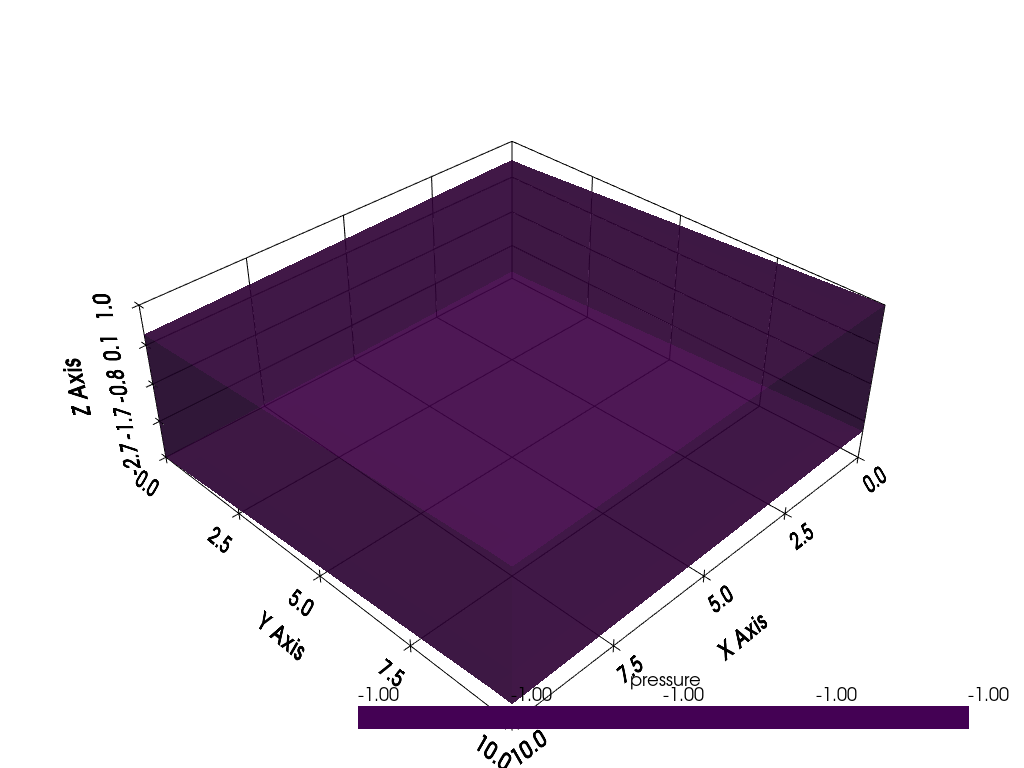

In [14]:
pl = pv.Plotter(notebook=True)
mesh = pv.read(os.path.join(simu_solution.workdir,
                                simu_solution.project_name,
                                'vtk/100.vtk',
                               )
       )
pl.add_mesh(mesh,
           opacity=0.7
           )
#pl.add_points(closest_positions,
#             color='red'
#             )
pl.show_grid()
pl.show()

(11, 7056)


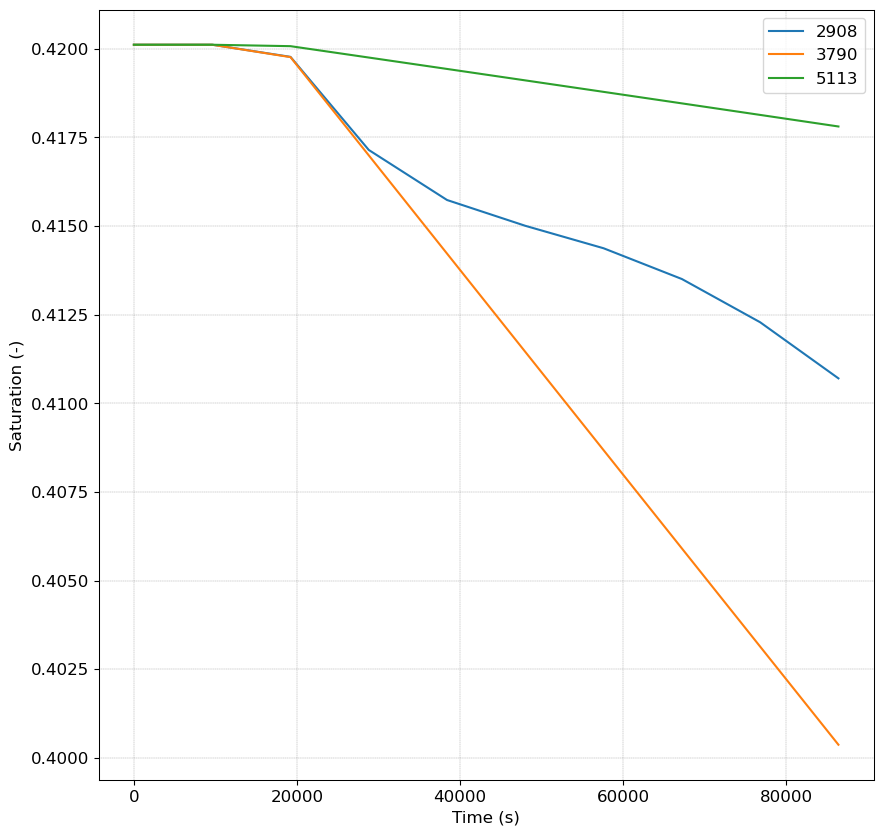

In [15]:
sw, sw_times = simu_solution.read_outputs('sw')
print(np.shape(sw))

fig, ax = plt.subplots()
for nn in nodeIds:
    ax.plot(sw.index,sw.iloc[:,nn],label=nn)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Saturation (-)')
plt.legend()

(add_noise_SMC)=
### Insert errors into the soil moisture

In [16]:
noise_std = 5e-4

In [17]:
SPP_df, FP_df =  simu_solution.read_inputs('soil',NVEG=1)
SPP_df.head()

PERMX     PERMY     PERMZ   ELSTOR  POROS  VGNCELL  VGRMCCELL  \
zone layer                                                                     
1    0      0.000188  0.000188  0.000188  0.00001   0.55     1.46       0.15   
     1      0.000188  0.000188  0.000188  0.00001   0.55     1.46       0.15   
     2      0.000188  0.000188  0.000188  0.00001   0.55     1.46       0.15   
     3      0.000188  0.000188  0.000188  0.00001   0.55     1.46       0.15   
     4      0.000188  0.000188  0.000188  0.00001   0.55     1.46       0.15   

            VGPSATCELL  
zone layer              
1    0         0.03125  
     1         0.03125  
     2         0.03125  
     3         0.03125  
     4         0.03125

In [18]:
POROS = SPP_df['POROS'].mean()
sw2SMC = sw*POROS

In [19]:
noise = np.random.normal(loc=0, 
                         scale=noise_std, 
                         size=sw.shape
                        )  # introducing Gaussian noise with mean 0 and standard deviation 0.01
sw2SMC_with_errors = sw2SMC + noise

Text(0, 0.5, 'Soil Moisture Content (%)')

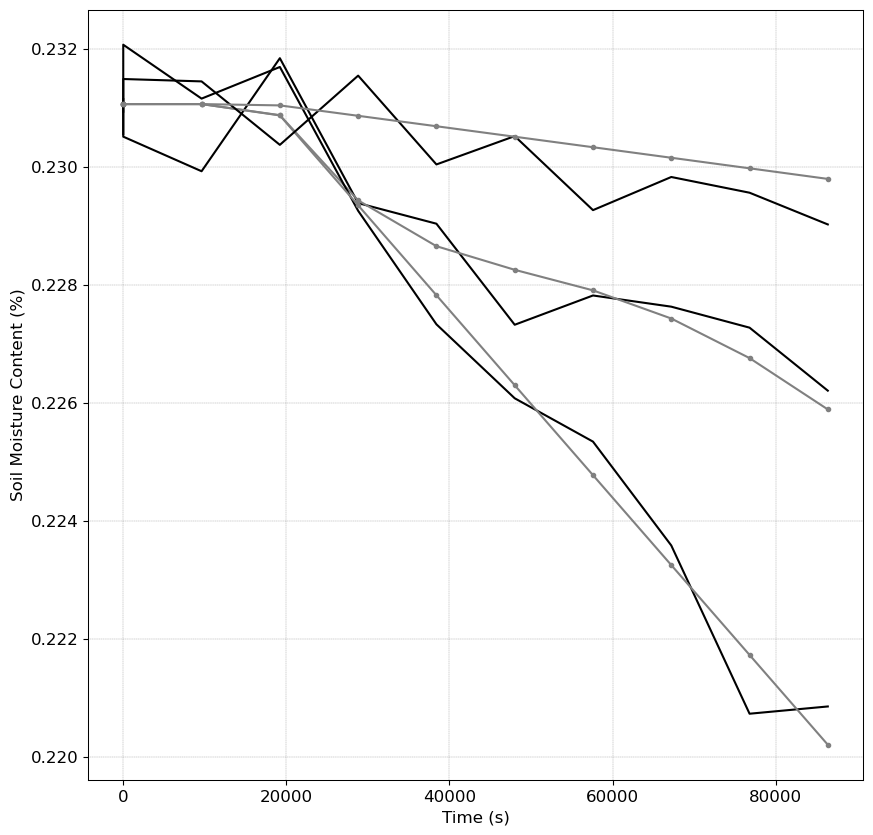

In [20]:
fig, ax = plt.subplots()
for nn in nodeIds:
    ax.plot(sw2SMC_with_errors.index,sw2SMC_with_errors.iloc[:,nn],color='k')
    ax.plot(sw2SMC.index,sw2SMC.iloc[:,nn],marker='.',color='grey')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Soil Moisture Content (%)')

In [21]:
# Round elements in sw_times to the nearest hundred ! this is a bug in the simulation
SMCtoAssimilate = np.hstack(sw2SMC_with_errors[np.hstack(nodeIds)])
sw_times_rounded = [round(swt, -2) for swt in sw_times]

In [22]:
# Round elements in sw_times to the nearest hundred ! this is a bug in the simulation
SMCtoAssimilate = sw2SMC_with_errors[np.hstack(nodeIds)]
sw_times_rounded = [round(swt, -2) for swt in sw_times]
common_elements = sorted(set(sw_times_rounded) & set(tatmbc))
indices_sw_times = [sw_times_rounded.index(element) for element in common_elements]
sw_times_common_rounded = [sw_times_rounded[idx] for idx in indices_sw_times]

In [23]:
SMCtoAssimilate_common = SMCtoAssimilate.iloc[indices_sw_times]

In [24]:
sw_times_common_rounded

[0.0,
 9600.0,
 19200.0,
 28800.0,
 38400.0,
 48000.0,
 57600.0,
 67200.0,
 76800.0,
 86400.0]

In [25]:
sensors_names = ['SMC'+str(i) for i in range(3)]

In [26]:
SMC_sensors_df = pd.DataFrame(SMCtoAssimilate_common,
                             )
SMC_sensors_df.columns = sensors_names
SMC_sensors_df = SMC_sensors_df.T
SMC_sensors_df.columns = sw_times_common_rounded
SMC_sensors_df.head()


,0.0,9600.0,19200.0,28800.0,38400.0,48000.0,57600.0,67200.0,76800.0,86400.0
SMC0,0.231148,0.229925,0.231841,0.229385,0.229036,0.227323,0.227819,0.227629,0.227273,0.226205
SMC1,0.230555,0.231156,0.231693,0.229255,0.227330,0.226076,0.225341,0.223581,0.220729,0.220852
SMC2,0.230935,0.231448,0.230372,0.231546,0.230040,0.230520,0.229266,0.229828,0.229561,0.229023


(prep_DA)=
## 1. Prepare Data Assimilation

First we define a dictionnary `scenario` describing which and how of the model parameters are **perturbated** and **updated**. One example case is considered, where initial condition and root depth is perturbated and updated sequentially: 
`ic_ZROOT_upd_ZROOT`

:::{admonition} Feddes parameters perturbation
In order to perturbate Feddes parameters we use typical range of possible values. 
For **ZROOT** the perturbation must be bounded within the limit of the simulation region. 
This condition is applied thanks to the dictionnary key `per_bounds`.
:::

- `per_type`
- `per_name`
- `per_nom`
- `per_sigma`
- `sampling_type`


(import_SMC_obs)=
### 2.1 Import SMC observations

```{tip}
    need to call `read_observations` as many times as variable to perturbate 
    return a dict merging all variable perturbate to parse into prepare_DA
```

In [27]:
dict_obs = {} # initiate the dictionnary
data_ass_time_s = sw_times
dict_obs

{}

`read_observations` takes as _mandatory arguments_: 
- `obs_2_add`: filename or value to add
- `mesh_nodes`: the closest mesh node where the sensor is located.

You can use ```nodeId, closest_pos = simu_solution.find_nearest_node(node_pos)```

- `data type`: 'swc'= soil water content. Options are: 'tensio' for tensiometers data, 'ERT' for electrical resistivity tomography data and others that you can check directly in the read_observations functions
- `tA`: assimilation time in second (**!this should be synchronise with atmbc times!**)
- `data_err`: absolute error of the sensor to consider

Optional arguments: 
- `colname`


In [28]:
%%capture
for i in range(len(SMC_sensors_df.index)):
    for j, tt in enumerate(SMC_sensors_df.columns):
        print(i,j)
        obs2add = SMC_sensors_df.iloc[SMC_sensors_df.index=='SMC'+str(i),j].values[0]
        dict_obs = read_observations( 
                                        dict_obs,
                                        obs_2_add=obs2add,
                                        mesh_nodes = nodeIds[i],
                                        data_type='swc',
                                        data_err=pts_data_err,
                                        #date_range=[args.startD,args.endD],
                                        colname=' m³/m³ Water Content',
                                        tA=tt
                                        )

In [29]:
data_measure_df = dictObs_2pd(dict_obs) 
data_measure_df

filename data_type          units      data  \
sensorNameidx assimilation time                                               
swc           0.0                   None       swc  $m^{3}/m^{3}$  0.231148   
              9600.0                None       swc  $m^{3}/m^{3}$  0.229925   
              19200.0               None       swc  $m^{3}/m^{3}$  0.231841   
              28800.0               None       swc  $m^{3}/m^{3}$  0.229385   
              38400.0               None       swc  $m^{3}/m^{3}$  0.229036   
              48000.0               None       swc  $m^{3}/m^{3}$  0.227323   
              57600.0               None       swc  $m^{3}/m^{3}$  0.227819   
              67200.0               None       swc  $m^{3}/m^{3}$  0.227629   
              76800.0               None       swc  $m^{3}/m^{3}$  0.227273   
              86400.0               None       swc  $m^{3}/m^{3}$  0.226205   
swc1          0.0                   None       swc  $m^{3}/m^{3}$  0.230555   
              9600.0                None       swc  $m^{3}/m^{3}$  0.231156   
              19200.0               None       swc  $m^{3}/m^{3}$  0.231693   
              28800.0               None       swc  $m^{3}/m^{3}$  0.229255   
              38400.0               None       swc  $m^{3}/m^{3}$  0.227330   
              48000.0               None       swc  $m^{3}/m^{3}$  0.226076   
              57600.0               None       swc  $m^{3}/m^{3}$  0.225341   
              67200.0               None       swc  $m^{3}/m^{3}$  0.223581   
              76800.0               None       swc  $m^{3}/m^{3}$  0.220729   
              86400.0               None       swc  $m^{3}/m^{3}$  0.220852   
swc2          0.0                   None       swc  $m^{3}/m^{3}$  0.230935   
              9600.0                None       swc  $m^{3}/m^{3}$  0.231448   
              19200.0               None       swc  $m^{3}/m^{3}$  0.230372   
              28800.0               None       swc  $m^{3}/m^{3}$  0.231546   
              38400.0               None       swc  $m^{3}/m^{3}$  0.230040   
              48000.0               None       swc  $m^{3}/m^{3}$  0.230520   
              57600.0               None       swc  $m^{3}/m^{3}$  0.229266   
              67200.0               None       swc  $m^{3}/m^{3}$  0.229828   
              76800.0               None       swc  $m^{3}/m^{3}$  0.229561   
              86400.0               None       swc  $m^{3}/m^{3}$  0.229023   

                                 data_err  mesh_nodes  assimilation_times  \
sensorNameidx assimilation time                                             
swc           0.0                    0.05        2908                 0.0   
              9600.0                 0.05        2908              9600.0   
              19200.0                0.05        2908             19200.0   
              28800.0                0.05        2908             28800.0   
              38400.0                0.05        2908             38400.0   
              48000.0                0.05        2908             48000.0   
              57600.0                0.05        2908             57600.0   
              67200.0                0.05        2908             67200.0   
              76800.0                0.05        2908             76800.0   
              86400.0                0.05        2908             86400.0   
swc1          0.0                    0.05        3790                 0.0   
              9600.0                 0.05        3790              9600.0   
              19200.0                0.05        3790             19200.0   
              28800.0                0.05        3790             28800.0   
              38400.0                0.05        3790             38400.0   
              48000.0                0.05        3790             48000.0   
              57600.0                0.05        3790             57600.0   
              67200.0                0.0

#### 2.1.1 Create observation covariance matrice 

In [30]:
%%capture
data_cov, data_pert, stacked_data_cov = make_data_cov(
                                                        simuWithDA,
                                                        dict_obs,
                                                        list_assimilated_obs = 'all',
                                                        nb_assimilation_times=len(dict_obs)
                                                        )

simuWithDA.stacked_data_cov = stacked_data_cov


In [31]:
len(data_measure_df.xs('swc').index)
len(dict_obs)

10

### 2.2 Perturbate

We first need to build the mesh

In [32]:
simuWithDA.update_soil()

🔄 Update soil

homogeneous soil

scenario    

In [33]:
scenario[scenario_selec]

{'per_type': ['None'],
 'per_name': ['ic'],
 'per_nom': [-1],
 'per_mean': [-1],
 'per_sigma': [1.75],
 'per_bounds': ['None'],
 'sampling_type': ['normal'],
 'transf_type': ['None'],
 'listUpdateParm': ['St. var.']}

scenario[scenario_selec] = {'per_type': [None],
                                 'per_name':['ic'],
                                 'per_nom':[-1],
                                 'per_mean':[-1],    
                                 'per_sigma': [1.75],
                                 'per_bounds': [None],
                                 'sampling_type': ['normal'],
                                 'transf_type':[None],
                                'listUpdateParm': ['St. var.'],
                                }

In [34]:
help(perturbate.perturbate)
NENS = 24
list_pert = perturbate.perturbate(
                                    simuWithDA, 
                                    scenario[scenario_selec], 
                                    NENS,
                                 )

Help on function perturbate in module pyCATHY.DA.perturbate:

perturbate(simu_DA, scenario, NENS, pertControl='Layer')
    Write a list of dictionaries, each containing all the informations on how to
    perturbate the parameters based on the scenario to consider
    
    
    pertControl = 'Layer'        
    Perturbation per zone is not yet implemented -  Assuming that the 
    dictionnary of perturbated parameters is build per layers i.e. 
    ks0= layer 0, ks1=layer 1, etc...



In [35]:
simuWithDA.project_name

'SMC_withDA'

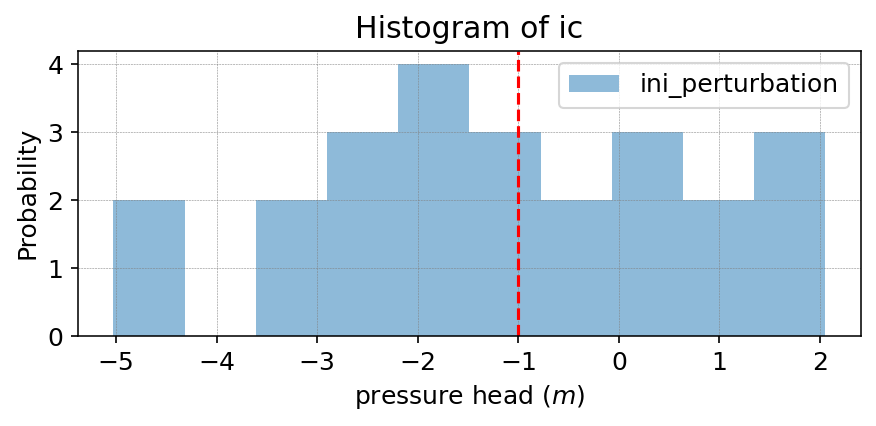

In [36]:
var_per_dict_stacked = {}
for dp in list_pert:
    # need to call perturbate_var as many times as variable to perturbate
    # return a dict merging all variable perturbate to parse into prepare_DA
    var_per_dict_stacked = perturbate_parm(
                                var_per_dict_stacked,
                                parm=dp, 
                                type_parm = dp['type_parm'], # can also be VAN GENUCHTEN PARAMETERS
                                mean =  dp['mean'],
                                sd =  dp['sd'],
                                sampling_type =  dp['sampling_type'],
                                ensemble_size =  dp['ensemble_size'], # size of the ensemble
                                per_type= dp['per_type'],
                                savefig= os.path.join(simuWithDA.workdir,
                                                      simuWithDA.project_name,
                                                      simuWithDA.project_name + dp['savefig'])
                                )

### 2.3 Define mapping operator 
For assimilation of soil moisture content data, the default mapping to get the water saturation is: porosity*SM
Please refer to ?? to see the mapping tools of pyCATHY

(solve)=
### 3. Run sequential DA

Simply use `run_DA_sequential()` with the `simu_DA` object

Required arguments are:
- **dict_obs**: dictionnary of observations
- **list_assimilated_obs**: list of observation to assimilate 
- **list_parm2update**: list of parameters to update 

Possible **optionnal** arguments are: 
- **parallel**: if True use multiple cores to run many realisations at the same time
- **DA_type**: type of data assimilation
- **threshold_rejected**: threshold above which the simulation stops (i.e. ensemble of rejected realisation too big)
- **damping**: add damping to inflate the covariance matrice


```{tip}
    During the execution **useful informations are displayed on the console** in order to follow the state of the DA. You can for example appreciated how many ensemble are rejected.
```


In [37]:
parallel = True

In [38]:
simuWithDA.update_parm(
                        IPRT1=2,
                        TRAFLAG=0,
                        DTMIN=1e-2,DTMAX=1e3,DELTAT=1
                        )

🔄 update parm file 

In [ ]:
simuWithDA.run_DA_sequential(
                              parallel=parallel,    
                              dict_obs= dict_obs,
                              list_assimilated_obs='all', # default
                              list_parm2update=scenario['ic_ZROOT_NOupdate']['listUpdateParm'],
                              DA_type='enkf_Evensen2009_Sakov',
                              dict_parm_pert=var_per_dict_stacked,
                              open_loop_run=False,
                              threshold_rejected=80,
                              # damping=1                   
                            )

🔄 update parm file 

🛠  Recompile src files [26s]

🍳 gfortran compilation [30s]

b''

😟 processor exe not found

Archie parameters not defined set defaults


─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Archie parameters not defined - Falling back to defaults

VGN parameters not defined - Falling back to defaults

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🔄 Update ensemble

🍳 gfortran compilation

👟 Run preprocessor

🔄 update parm file 

🛠  Recompile src files [34s]

🍳 gfortran compilation [38s]

b''

👟 Run processor

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

🧽 update input ensemble

🔄 update parm file 

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

['Adjusting NPRT with respect to time of interests requested\n']

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

👟 Run hydrological model

✅ check scenarii before analysis

❌ df_mbeconv['time']0.02, ens_nb:5

❌ df_mbeconv['time']0.0725, ens_nb:15

cannot read mbeconv


❌ df_mbeconv['time']0.0725, ens_nb:22

❌ df_mbeconv['time']0.025625, ens_nb:23

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (3,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

!positive pressure heads observed!


✅ check scenarii post update

─────────────────────────────────────── 📍 end of time step (s) 0/86400 📍 ────────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 1/10 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 1/10 🔴 ───────────────────────────────────────────

─────────────────────────────────── 🎯 % of valid ensemble: 79.16666666666667🎯 ───────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (3,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

✅ check scenarii post update

────────────────────────────────────── 📍 end of time step (s) 9600/86400 📍 ──────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 2/10 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 2/10 🔴 ───────────────────────────────────────────

─────────────────────────────────── 🎯 % of valid ensemble: 79.16666666666667🎯 ───────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (3,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 19200/86400 📍 ──────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 3/10 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 3/10 🔴 ───────────────────────────────────────────

─────────────────────────────────── 🎯 % of valid ensemble: 79.16666666666667🎯 ───────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (3,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 28800/86400 📍 ──────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 4/10 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 4/10 🔴 ───────────────────────────────────────────

─────────────────────────────────── 🎯 % of valid ensemble: 79.16666666666667🎯 ───────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (3,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 38400/86400 📍 ──────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 5/10 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 5/10 🔴 ───────────────────────────────────────────

─────────────────────────────────── 🎯 % of valid ensemble: 79.16666666666667🎯 ───────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (3,)
                                 --> Observations --> all

parm size: 0


SakovTrue